<a href="https://colab.research.google.com/github/Danial-sb/Brain_Tumor_Classification/blob/main/Brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing libraries**

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.applications.vgg16 import preprocess_input,VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,Flatten,Input
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import visualkeras

**Hyperparameters**

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/brain_tumor_classification',
                                                              shuffle = True,
                                                              image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                              batch_size = BATCH_SIZE)

Found 2870 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

**Visualization**

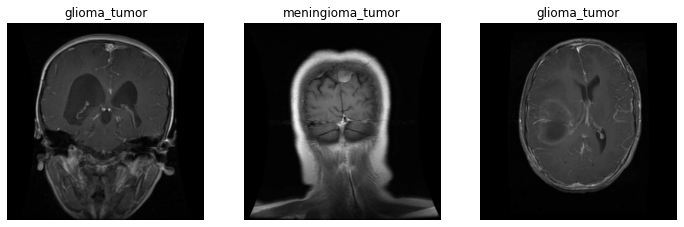

In [ ]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[i].numpy()])

**Partitioning the dataset**

In [7]:
def get_dataset_partitions(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  if shuffle:
    ds.shuffle(shuffle_size, seed = 12)

  training_size = int(train_split * len(ds))
  val_size = int(val_split * len(ds))

  train_ds = ds.take(training_size)
  val_ds = ds.skip(training_size).take(val_size)
  test_ds = ds.skip(training_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
      layers.experimental.preprocessing.Rescaling(1./255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
      layers.experimental.preprocessing.RandomRotation(0.2)
])

In [12]:
callback = EarlyStopping(min_delta = 0.001, patience = 10, restore_best_weights = True)

**Implementing a traditional CNN model**

In [14]:
def trad_CNN(train_data, validation_data, batch_size = BATCH_SIZE, image_size = IMAGE_SIZE, channels = CHANNELS, epochs = EPOCHS):

    input_shape = (batch_size, image_size, image_size, channels)
    n_classes = 4

    model = tf.keras.Sequential([
            data_augmentation,
            layers.Conv2D(64, (3,3), activation='relu', padding = 'same', input_shape = input_shape),
            layers.MaxPooling2D((2,2)),
            layers.BatchNormalization(),

            layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
            layers.MaxPooling2D((2,2)),
            layers.BatchNormalization(),

            layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
            layers.MaxPooling2D((2,2)),
            layers.BatchNormalization(),

            layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'),
            layers.MaxPooling2D((2,2)),
            layers.BatchNormalization(),

            layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'),
            layers.MaxPooling2D((2,2)),
            layers.BatchNormalization(),

            layers.Conv2D(512, (3,3), activation = 'relu', padding = 'same'),
            layers.MaxPooling2D((2,2)),
            layers.BatchNormalization(),

            layers.Flatten(),
            layers.Dense(1024, activation = 'relu'),
            layers.Dropout(0.2),
            layers.Dense(512, activation = 'relu'),
            layers.Dropout(0.2),
            layers.Dense(n_classes, activation='softmax')
    ])
    model.build(input_shape = input_shape)
    model.summary()
    model.compile( optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    history = model.fit(train_data, batch_size = batch_size, validation_data = validation_data, verbose = 1, epochs = epochs, callbacks = callback)

    return model, history

In [ ]:
trad_cnn_model, trad_cnn_history = trad_CNN(train_ds, val_ds)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 256, 256, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 128, 128, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (32, 128, 128, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (32, 128, 128, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 64, 64, 128)       

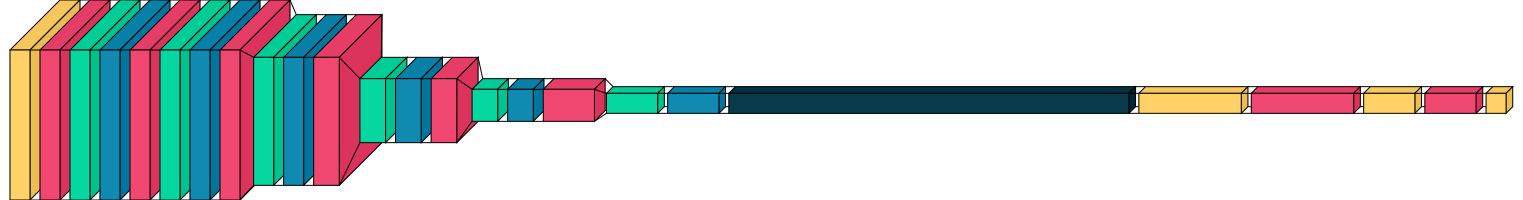

In [ ]:
visualkeras.layered_view(trad_cnn_model, max_xy=150)

**Evaluation**

In [ ]:
acc = trad_cnn_history.history['accuracy']
val_acc = trad_cnn_history.history['val_accuracy']
loss = trad_cnn_history.history['loss']
val_loss = trad_cnn_history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

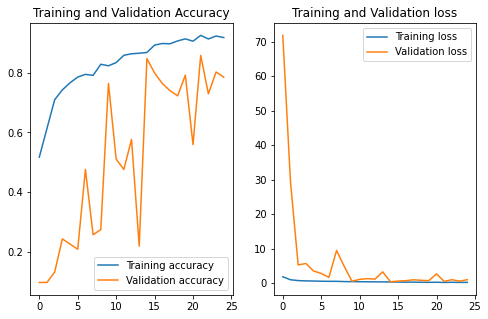

In [ ]:
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.plot(range(25), acc, label = 'Training accuracy')
plt.plot(range(25), val_acc, label = 'Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(25), loss, label = 'Training loss')
plt.plot(range(25), val_loss, label = 'Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

**Using transfer learning (VGG16) for classifying tumors.**

In [13]:
def VGG16_model(train_data, validation_data, batch_size = BATCH_SIZE, image_size = IMAGE_SIZE, channels = CHANNELS, epochs = EPOCHS):

    input_shape = (batch_size, image_size, image_size, channels)
    n_classes = 4

    vgg_model = VGG16(weights='imagenet',include_top=False, input_shape= (IMAGE_SIZE, IMAGE_SIZE)+(3,))
    for layers in vgg_model.layers:
      layers.trainable = False

    x = vgg_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.15)(x)
    output = Dense(n_classes,activation='softmax')(x)

    model = tf.keras.Model(inputs = vgg_model.input,outputs=output)
    model.build(input_shape = input_shape)
    model.summary()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, batch_size = batch_size, validation_data = validation_data, verbose = 1, epochs = epochs, callbacks = callback)

    return model, history

In [14]:
vgg_cnn_model, vgg_cnn_history = VGG16_model(train_ds, val_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

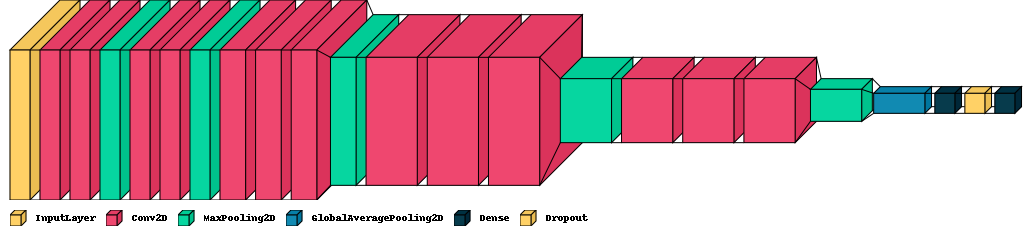

In [15]:
visualkeras.layered_view(vgg_cnn_model, max_xy=150, legend = True)

**Evaluation**

In [17]:
acc = vgg_cnn_history.history['accuracy']
val_acc = vgg_cnn_history.history['val_accuracy']
loss = vgg_cnn_history.history['loss']
val_loss = vgg_cnn_history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

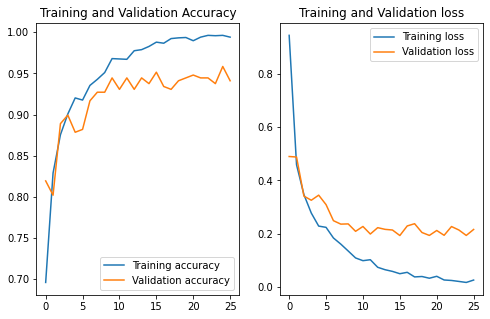

In [18]:
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.plot(range(26), acc, label = 'Training accuracy')
plt.plot(range(26), val_acc, label = 'Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(26), loss, label = 'Training loss')
plt.plot(range(26), val_loss, label = 'Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

In [20]:
vgg_cnn_model.evaluate(test_ds)

9/9 [==============================] - 15s 451ms/step - loss: 0.1702 - accuracy: 0.9532


[0.1702335923910141, 0.9532374143600464]

**Prediction on the test data**





1/1 [==============================] - 0s 41ms/step
predicted as: glioma_tumor


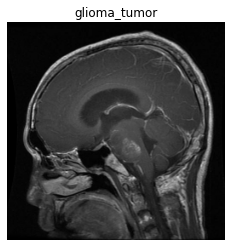

In [49]:
for image_batch, label_batch in test_ds.take(1):
  plt.imshow(image_batch[15].numpy().astype('uint8'))
  plt.axis('off')
  plt.title(class_names[label_batch[15]])

prediction = vgg_cnn_model.predict(image_batch)
print("predicted as: " + class_names[np.argmax(prediction[15])])

It was shown that **VGG16** model worked more efficiently, because of two main reasons:

1.   The validation accuracy and test accuracy is higher than the other method.
2.   Time of computation and computation power is required lesser than the traditional method as pretrained weights are used. (if you look at the model summary, the trainable parameters are just 66,180, compared to the first method which had 11,207,812 trainable parameters.

